# Generate a synthetic lens set from empirical velocity dispersion function and intrinsic shape priors

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd 



In [2]:
# from slsim.Deflectors.velocity_dispersion import schechter_velocity_dispersion_function

from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d
from scipy.stats import truncnorm


## The velocity dispersion distribution

In [ ]:
data_slacs = pd.read_csv('./tableA1.txt', delim_whitespace=True, comment='#', header=None, on_bad_lines='skip')

# select only the lenses
flag_lens = (data_slacs[17].values.astype('str') == 'A') & (data_slacs[18].values.astype('int') == 0)

data_slacs = data_slacs[flag_lens]

/tmp/ipykernel_1890539/578553144.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data_slacs = pd.read_csv('./tableA1.txt', delim_whitespace=True, comment='#', header=None, on_bad_lines='skip')


True
False
True


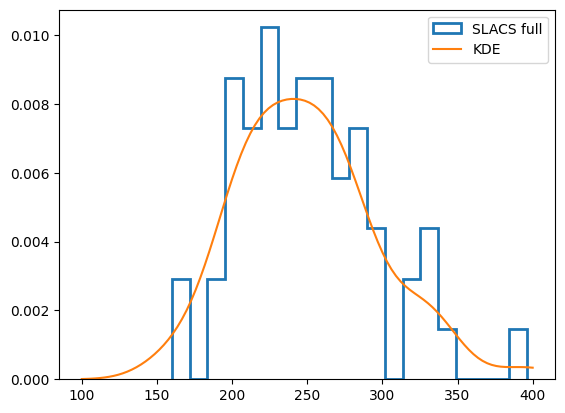

In [5]:
sigma_slacs = data_slacs[11].values.astype('float')
print(np.all(np.isfinite(sigma_slacs)) == True)
print(np.all(sigma_slacs > 0.))

sigma_mask = sigma_slacs > 0.
sigma_slacs = sigma_slacs[sigma_mask]
print(np.all(sigma_slacs > 0.))

plt.hist(sigma_slacs, bins = 20, density = True, histtype='step', lw=2, label = 'SLACS full')

sigma_kde = gaussian_kde(sigma_slacs)

sigma_sample = np.linspace(100, 400, 100)
plt.plot(sigma_sample, sigma_kde(sigma_sample), label = 'KDE')
plt.legend()
plt.show()

## Half-light radius

True
True


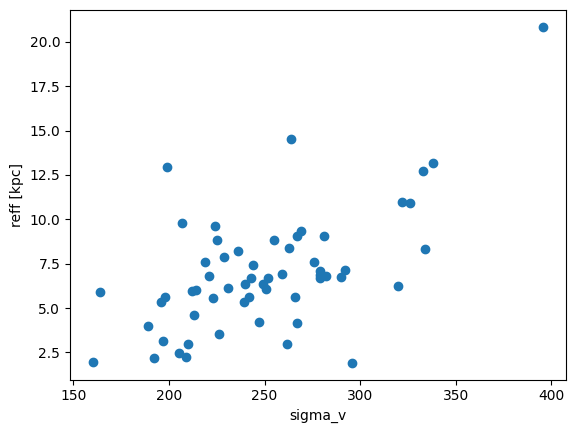

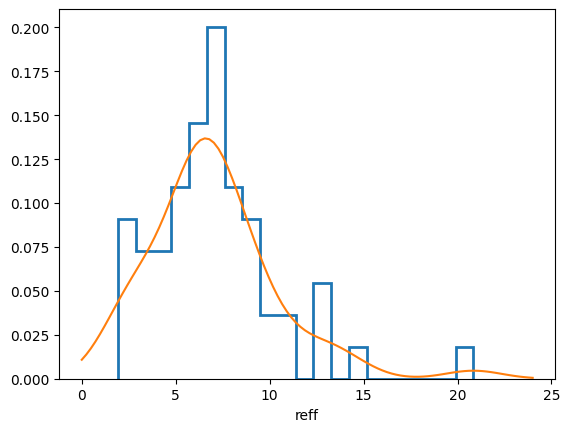

In [6]:
reff_slacs = data_slacs[7].values.astype('float')[sigma_mask]
print(np.all(np.isfinite(reff_slacs)) == True)
print(np.all(reff_slacs > 0))

from astropy.cosmology import FlatLambdaCDM
cosmology = FlatLambdaCDM(H0=70, Om0=0.3)

# convert effective radius to physical unit
zlens_slacs = data_slacs[3].values.astype('float')
zlens_slacs = zlens_slacs[sigma_mask]
Dd = cosmology.angular_diameter_distance(zlens_slacs)
reff_kpc = (reff_slacs / 3600 * np.pi / 180 * Dd * 1e3).value

plt.figure()
plt.scatter(sigma_slacs, reff_kpc)
plt.xlabel('sigma_v')
plt.ylabel('reff [kpc]')
plt.show()

plt.figure()
plt.hist(reff_kpc, bins = 20, density = True, histtype='step', lw=2, label = 'SLACS full')

reff_kpc_kde = gaussian_kde(reff_kpc, bw_method='scott')
reff_sample = np.linspace(0, 24, 100)

plt.plot(reff_sample, reff_kpc_kde(reff_sample), label = 'SLACS full')
plt.xlabel('reff')
plt.show()



## Sample the velocity dispersion and the effective radius on a grid

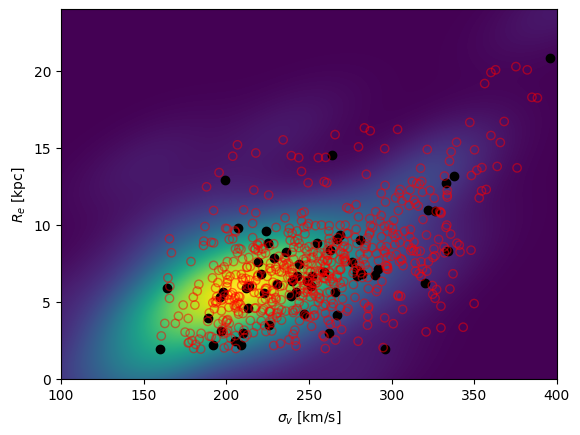

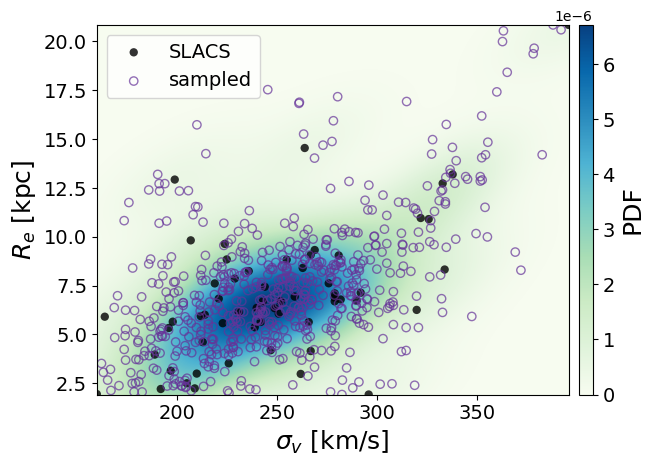

In [11]:
# 2d kde estimation of [sigma, reff]

data = np.vstack([sigma_slacs, reff_kpc])
data_kde = gaussian_kde(data, bw_method='silverman')

sigma_min = sigma_slacs.min()
sigma_max = sigma_slacs.max()
reff_min = reff_kpc.min()
reff_max = reff_kpc.max()

grid_x, grid_y = np.mgrid[sigma_min: sigma_max: 1000j, reff_min: reff_max: 1000j]
grid_ravel = np.vstack([grid_x.ravel(), grid_y.ravel()])
data_kde_eval = np.reshape(data_kde(grid_ravel).T, grid_x.shape)

# normalize the density
data_kde_eval = data_kde_eval / np.sum(data_kde_eval)

fig, ax = plt.subplots()
ax.imshow(np.rot90(data_kde_eval), cmap=plt.cm.viridis,
          extent=[sigma_sample.min(), sigma_sample.max(), reff_sample.min(), reff_sample.max()])
ax.scatter(sigma_slacs, reff_kpc, c = 'k')
ax.set_xlim([sigma_sample.min(), sigma_sample.max()])
ax.set_ylim([reff_sample.min(), reff_sample.max()])
ax.set_aspect('auto')

# fig, ax = plt.subplots()
# ax.pcolormesh(grid_x, grid_y, data_kde_eval, cmap=plt.cm.viridis, shading='auto')
# ax.scatter(sigma_slacs, reff_kpc, c='k', label="SLACS")
# ax.set_xlim([sigma_min, sigma_max])
# ax.set_ylim([reff_min, reff_max])
# ax.set_xlabel(r'$\sigma$')
# ax.set_ylabel(r'$R_\mathrm{eff}$')
# ax.set_aspect('auto')
# ax.legend()

# randomly sample from the grid
sample_indices = np.random.choice(
    np.arange(data_kde_eval.size),
    size=600,
    p=data_kde_eval.ravel()
)


sigma_draw, reff_draw = grid_ravel[0][sample_indices], grid_ravel[1][sample_indices]

plt.scatter(sigma_draw, reff_draw, facecolors= 'none', edgecolors='r', alpha = 0.5)
plt.xlabel(r'$\sigma_v$ [km/s]')
plt.ylabel(r'$R_e$ [kpc]')
plt.show()

# plotting the synthetic data I used in the paper
data_sampled = np.load('./synthetic_oblate.npy')
sigma_data, reff_data = data_sampled[:2]

fig, ax = plt.subplots()
im = ax.imshow(np.rot90(data_kde_eval), cmap=plt.cm.GnBu,
          extent=[sigma_min, sigma_max, reff_min, reff_max])
ax.scatter(sigma_slacs, reff_kpc, c = 'k', alpha = 0.8, edgecolors = 'none', label = 'SLACS')
ax.set_xlim([sigma_min, sigma_max])
ax.set_ylim([reff_min, reff_max])
ax.set_aspect('auto')

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.1)

ax.scatter(sigma_data, reff_data, facecolors= 'none', edgecolors='rebeccapurple', alpha = 0.7, label = 'sampled')
ax.set_xlabel(r'$\sigma_v$ [km/s]', size = 18)
ax.set_ylabel(r'$R_e$ [kpc]', size = 18)
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('PDF', size = 18)

for ax1 in fig.axes:
    ax1.tick_params(labelsize = 14)

ax.legend(prop = {'size': 14})
plt.savefig('./synthetic_lens_slacs_kde.pdf', dpi=300, bbox_inches='tight')

plt.show()

## The intrinsic shape distribution

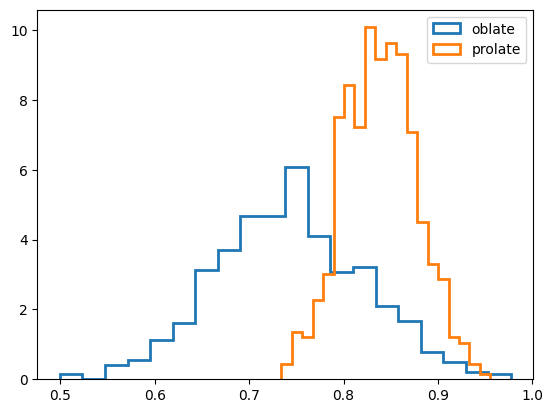

In [8]:
def qintr_prior(mu, sigma, num): # sample q_intr from truncated Gaussian prior
    lo_lim, hi_lim = 0, 1
    lo_transformed = (lo_lim - mu) / sigma
    hi_transformed = (hi_lim - mu) / sigma
    qintr_prior = truncnorm(lo_transformed, hi_transformed, loc = mu, scale = sigma)
    return qintr_prior.rvs(size = num)

mu_qintr_oblate, sigma_qintr_oblate = 0.74, 0.08
mu_qintr_prolate, sigma_qintr_prolate = 0.84, 0.04

qintr_oblate = qintr_prior(mu_qintr_oblate, sigma_qintr_oblate, 600)
qintr_prolate = qintr_prior(mu_qintr_prolate, sigma_qintr_prolate, 600)

plt.hist(qintr_oblate, histtype='step', lw=2, label = 'oblate', density = True, bins = 20)
plt.hist(qintr_prolate, histtype='step', lw=2, label = 'prolate', density = True, bins = 20)

plt.legend()
plt.show()

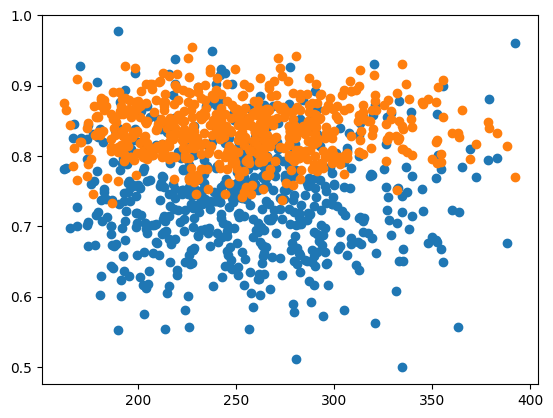

In [9]:
data_oblate = np.vstack([sigma_draw, reff_draw, qintr_oblate])

data_prolate = np.vstack([sigma_draw, reff_draw, qintr_prolate])

plt.scatter(data_oblate[0], data_oblate[2])
plt.scatter(data_prolate[0], data_prolate[2])

save_sampled_data = True

if save_sampled_data:
    np.save('./synthetic_oblate.npy', data_oblate)
    np.save('./synthetic_prolate.npy', data_prolate)

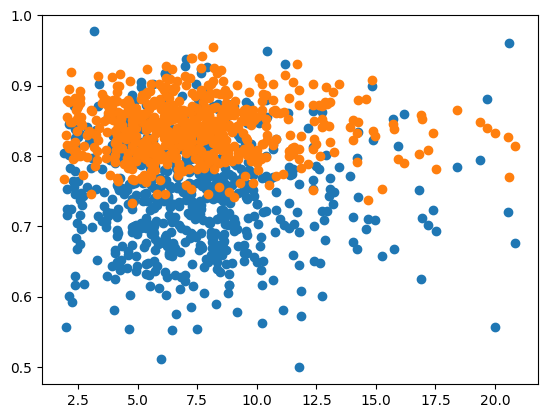

In [10]:
plt.scatter(data_oblate[1], data_oblate[2])
plt.scatter(data_prolate[1], data_prolate[2])